<a href="https://colab.research.google.com/github/Meetra21/Brain_MRI_segmentation/blob/main/Brain_MRI_segmentation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import external libraries
from glob import glob
from tqdm import tqdm_notebook, tnrange

# Import system libraries
import os
import pathlib
import random
import itertools
import time


Here's a brief explanation of each line of code:

**from glob import glob:** The glob function is used to search for files and directories that match a specified pattern. In this case, we are importing the glob function from the glob module.

**from tqdm import tqdm_notebook, tnrange:** The tqdm library provides a progress bar that can be used to visualize the progress of iterative processes such as loops or data loading. We are importing two specific functions tqdm_notebook and tnrange for use in Jupyter notebook environments.

The tqdm_notebook function is used to display a progress bar in Jupyter Notebook environments. It is a specialized version of the tqdm function that is designed to work with the Notebook interface, allowing users to visualize the progress of long-running tasks in real-time.

The tqdm_notebook function is similar to the tqdm function, but it replaces the default text-based progress bar with a more visually appealing and interactive progress bar that updates dynamically as the task progresses. The progress bar is displayed directly in the Jupyter Notebook output cell, making it easy to monitor the progress of long-running tasks without having to print status updates to the console.


**import os:** The os module provides a way to interact with the underlying operating system, including functions for file I/O, working with directories, and managing processes.

File I/O (Input/Output) refers to the process of reading from and writing to files on a file system.

**import pathlib:** The pathlib module provides an object-oriented interface to the file system, making it easier to work with file paths and perform file I/O operations.

**import random:** The random module provides functions for generating random numbers and sequences.

**import itertools:** The itertools module provides functions for working with iterators and generating combinations and permutations of sequences.

**import time:** The time module provides functions for measuring time and performing time-related operations.

In [ ]:
import cv2
import numpy as np
import pandas as pd
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline


Here's an explanation of some of the imported functions:

**rgb2gray:** is used to convert RGB images to grayscale.

**label:** is used to label connected regions in a binary image. It is often used for image segmentation.

**resize:** is used to resize images to a specified size.

**train_test_split:** is used to split a dataset into training and testing sets. This is useful for evaluating machine learning models.

**imread:** is used to read image files into numpy arrays.

**imshow:** is used to display images in a matplotlib plot.

**concatenate_images:** is used to concatenate two or more images horizontally or vertically.

# **Upload a dataset from Kaggle**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (6).json


{'kaggle.json': b'{"username":"anouri","key":"3464baaaa0126fcf846c455c3fbbdcc9"}'}

In [ ]:
# mounts Google Drive to Google Colab, so that we can access files stored on Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q kaggle

In [ ]:
#copies the Kaggle API key file ('kaggle.json') from Google Drive to the '/content' #directory in Google Colab.
#This file is used to authenticate Kaggle account when using the Kaggle API to download datasets.
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' '/content'

In [ ]:
import zipfile
import os

#sets the 'KAGGLE_CONFIG_DIR' environment variable to '/content',
#which tells the Kaggle API to look for the 'kaggle.json' file in the '/content' directory.
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
# use the Kaggle API to download the Kaggle 3M MRI dataset to the '/content' directory in #Google Colab.
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#extracts the contents of the lgg-mri-segmentation.zip file to
#the /content/lgg-mri-segmentation directory in Google Colab.
!unzip -qn /content/lgg-mri-segmentation.zip -d /content/lgg-mri-segmentation


In [ ]:
import pandas as pd                  # For manipulation
data_path = '/content/lgg-mri-segmentation/kaggle_3m/data.csv'
df = pd.read_csv(data_path) # Reading the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

we can see that the dataset contains 110 entries, with each entry corresponding to a unique patient. The dataset consists of 18 columns, with each column representing a specific feature of the patient's cancer diagnosis or demographic information.

The Patient column is an object data type, while the remaining columns are either float or integer data types. There are missing values present in several columns, with the highest number of missing values in the RNASeqCluster column.

The RNASeqCluster, MethylationCluster, CNCluster, RPPACluster, OncosignCluster, histological_type, neoplasm_histologic_grade, tumor_tissue_site, laterality, tumor_location, gender, age_at_initial_pathologic, race, ethnicity, and death01 columns are all relevant to cancer diagnosis and prognosis.

In [ ]:
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


This function in below, generates a dataframe from the provided dataset.





In [ ]:
import pandas as pd
import pathlib
from sklearn.model_selection import train_test_split
from glob import glob

data_dir = '/content/lgg-mri-segmentation/kaggle_3m'

def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df


In [ ]:
df.head(2)

,images_paths,masks_paths
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...


This function in below, creates image generators for the dataset and applies data augmentation techniques.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40

    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)


This function in below, displays a sample of images from the provided dataset.





In [ ]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

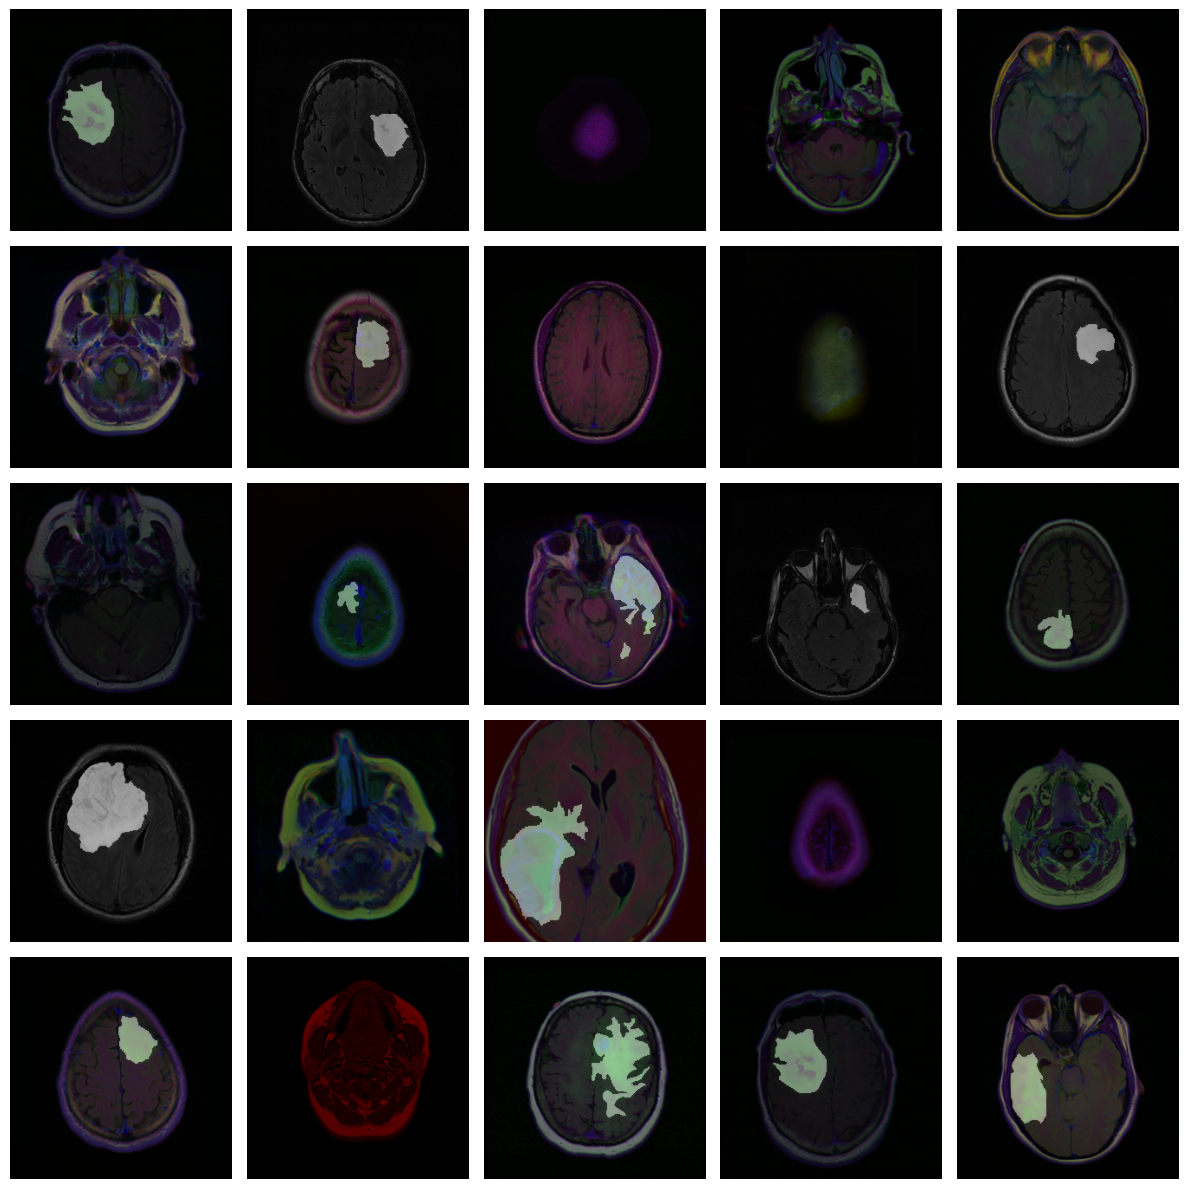

In [ ]:
show_images(list(train_df['images_paths']), list(train_df['masks_paths']))


This code in below, read data.

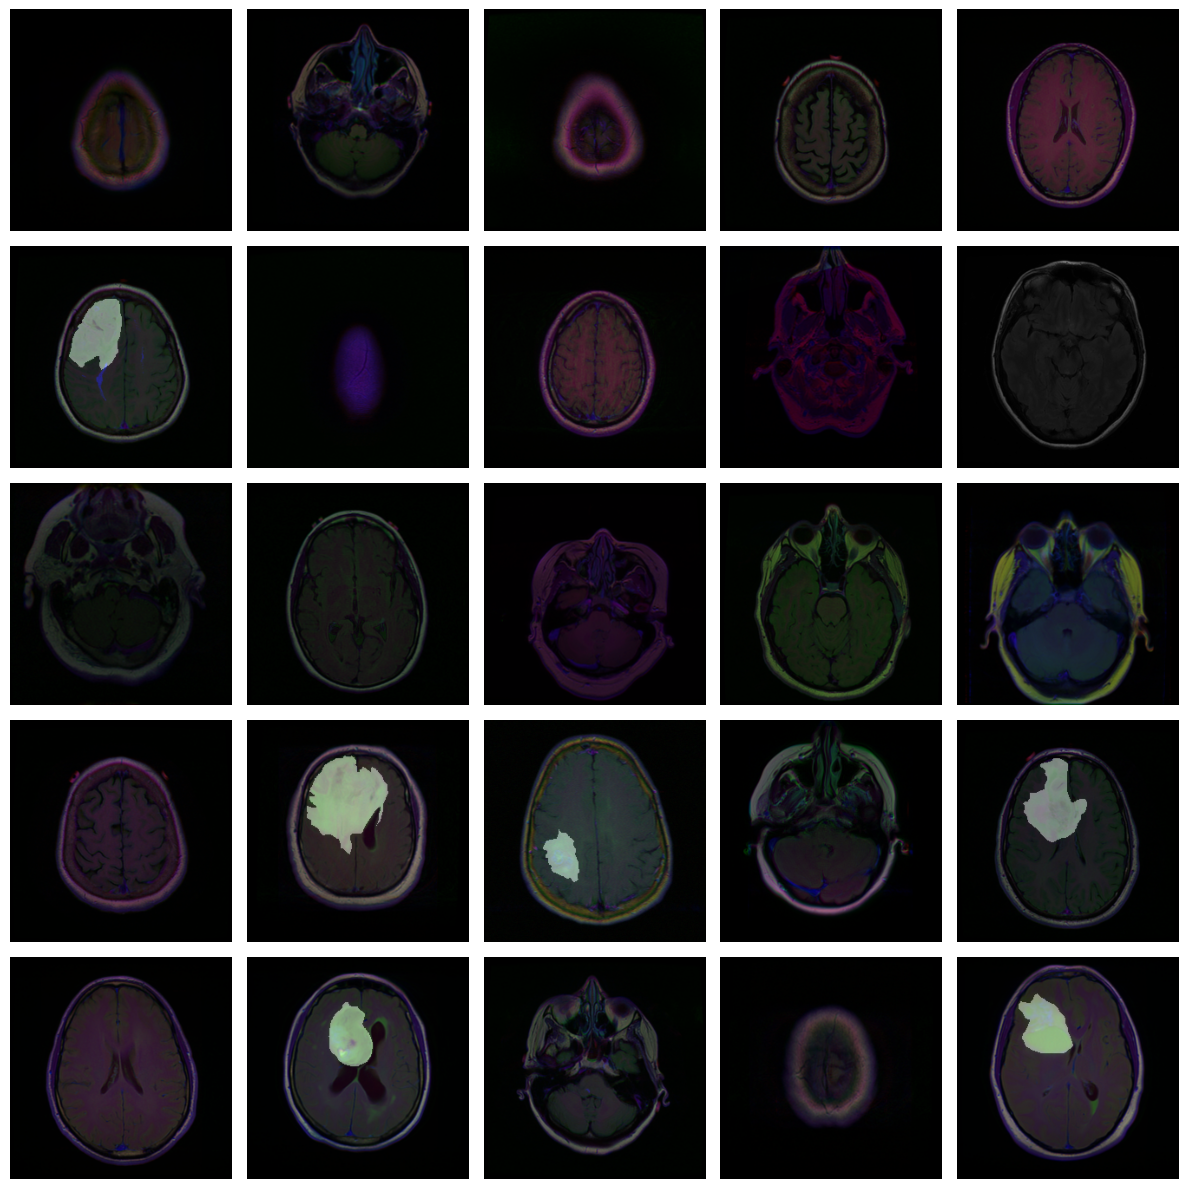

In [ ]:
data_dir = '/content/lgg-mri-segmentation/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)


tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

In [ ]:
!pip install -q tqdm


In [ ]:
# Import external libraries
from glob import glob
from tqdm import tqdm_notebook, tnrange

# Import system libraries
import os
import pathlib
import random
import itertools
import time


Here's a brief explanation of each line of code:

**from glob import glob:** The glob function is used to search for files and directories that match a specified pattern. In this case, we are importing the glob function from the glob module.

**from tqdm import tqdm_notebook, tnrange:** The tqdm library provides a progress bar that can be used to visualize the progress of iterative processes such as loops or data loading. We are importing two specific functions tqdm_notebook and tnrange for use in Jupyter notebook environments.

The tqdm_notebook function is used to display a progress bar in Jupyter Notebook environments. It is a specialized version of the tqdm function that is designed to work with the Notebook interface, allowing users to visualize the progress of long-running tasks in real-time.

The tqdm_notebook function is similar to the tqdm function, but it replaces the default text-based progress bar with a more visually appealing and interactive progress bar that updates dynamically as the task progresses. The progress bar is displayed directly in the Jupyter Notebook output cell, making it easy to monitor the progress of long-running tasks without having to print status updates to the console.


**import os:** The os module provides a way to interact with the underlying operating system, including functions for file I/O, working with directories, and managing processes.

File I/O (Input/Output) refers to the process of reading from and writing to files on a file system.

**import pathlib:** The pathlib module provides an object-oriented interface to the file system, making it easier to work with file paths and perform file I/O operations.

**import random:** The random module provides functions for generating random numbers and sequences.

**import itertools:** The itertools module provides functions for working with iterators and generating combinations and permutations of sequences.

**import time:** The time module provides functions for measuring time and performing time-related operations.